In [20]:
import os
import sys
import numpy as np
from numpy import array
import random
import pandas as pd
# timer
import time
import pickle
import shutil

In [21]:
# Import necessary libraries for time-series statistical models
try:
    from statsmodels.tsa.arima.model import ARIMA
except ModuleNotFoundError:
    # Install statsmodels if not available
    !pip install statsmodels
    from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.arima_process import ArmaProcess

### TensorFlow library
import tensorflow
######## GPU activation ###########
device_name = tensorflow.test.gpu_device_name()
if len(device_name) > 0:
    print("Found GPU at: {}".format(device_name))
else:
    device_name = "/device:CPU:0"
    print("No GPU, using {}.".format(device_name))
#######################################

# Keras is the high-level API of the TensorFlow platform
import keras
from keras.models import Sequential
from keras.layers import Input, Dense, Dropout, LeakyReLU, PReLU
from keras.optimizers import Adam, RMSprop, SGD

# Configuration of Keras optimizers
keras.optimizers.Adam(
    beta_1=0.9, beta_2=0.999,
    epsilon=1e-07)
keras.optimizers.SGD(
    momentum=0.0)
keras.optimizers.RMSprop(
    rho=0.9,
    momentum=0.0,
    epsilon=1e-07)

# Import EarlyStopping from Keras for later use
from keras.callbacks import EarlyStopping

# Import KerasTuner for hyperparameter search
try:
    import keras_tuner as kt
except ModuleNotFoundError:
    # Install keras-tuner if not available
    !pip install keras-tuner
    import keras_tuner as kt

from keras_tuner.tuners import RandomSearch
from tensorflow.keras.utils import plot_model

# Hide warnings from TensorFlow
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


No GPU, using /device:CPU:0.


In [22]:
# Plotting and warnings
import matplotlib.pyplot as plt  # data plotting
from   matplotlib import rcParams
rcParams['figure.figsize']     = [18,9]
rcParams['lines.markersize']   = 12         # marker size in points
rcParams['axes.labelsize']     = 15
rcParams['axes.titlesize']     = 12
rcParams['figure.dpi']         = 120
# for plotting and styling
import seaborn as sns
sns.set(context="notebook", palette="deep",
        style = 'darkgrid' ,font_scale = .9, color_codes=True)

# Visualize the training dataset
kolor = ['#78C850',  # Grass
          '#F08030',  # Fire
          '#6890F0',  # Water
          '#A8B820',  # Bug
          '#A8A878',  # Normal
          '#A040A0',  # Poison
          '#F8D030',  # Electric
          '#E0C068',  # Ground
          '#EE99AC',  # Fairy
          '#C03028',  # Fighting
          '#F85888',  # Psychic
          '#B8A038',  # Rock
          '#705898',  # Ghost
          '#98D8D8',  # Ice
          '#7038F8',  # Dragon
         ]

> Setting up the Keras Tuner

In [23]:
# MLP Custom Model
def build_model(hp):

    """
    Function to build a neural network model.

    Parameters
    ----------
    hp : object
        A HyperParameters object to tune the model's hyperparameters.

    Returns
    -------
    keras.models.Sequential
        A sequential neural network model.
    """
    #  Model-Building Function
    n_samples =  data_r['Nsamples']
    input_shape = round(np.log2(n_samples))-1
    ######################################################################################
    hp_activ = hp.Choice('activation', data_r['f_activ'])

    hp_loss = hp.Choice('mean_squared_error','mean_squared_logarithmic_error')
    # Choose an optimizer based on the search space
    hp_opt = hp.Choice('optimizer', ['adam', 'sgd', 'rmsprop'])
    ######################################################################################

    model = Sequential()
    model.add(Input(shape = input_shape )) #????

    for l in range(hp.Int('num_layers',1,4)):
      # Tune the number of units in each l dense layer
      model.add(Dense(units=hp.Int(f'units1_{l}', min_value=int(n_samples/15),
                max_value=int(n_samples/3), step=int(n_samples/15)),
                      #activation = hp_activ,
                      activation = hp.Choice(f'activation_{l}', data_r['f_activ']),
                     kernel_initializer='he_uniform'))
      # tune the dropout value in each l lalyer
      model.add(Dropout(rate = hp.Float(f'dropout_{l}',
                                            min_value=0, max_value=0.5, step=.1)))

    model.add(Dense(1, activation=hp_activ))

    # Tune the learning rate for the optimizer

    hp_lr = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    model.compile(optimizer = hp_opt,
                loss = hp.Choice('Loss',data_r['LossSet']),
                metrics=['MeanSquaredError'])
    return model

> Data creation

In [24]:
# time-series models

def timeseries(n_samples,process:int)-> np.ndarray:
    """
    Generates a synthetic time series.

    Parameters
    ----------
    n_samples : int
        The number of samples in the time series.
    process : int
        The type of process to generate the time series:
            1 - Random walk.
            2 - ARMA(3,3) model.
            3 - ARMA(2,2) model.

    Returns
    -------
    np.ndarray
        The generated time series.
    """
    np.random.seed(np.random.randint(low = 0, high = 99, size = 1))
    if process == 1:
        # random walk
        AR_μ = RandomWalk(64,n_samples)
        lab ='random walk'
        # ARMA  models
    elif process == 2:
        # ARMA(3, 3) model
        # alphas = array([-.933, 0.003, -0.003]) ; betas  = array([ .01, -.001, 0.001])
        alphas = array([-random.randint(840, 960)/1000, -random.randint(1, 9)/1000, --random.randint(1, 9)/1000]) #
        betas  = array([ random.randint(5, 15)/1000, -random.randint(5, 15)/10000, random.randint(5, 15)/10000])
        lab ='rARMA(3, 3)'
    elif process == 3:
        # ARMA(2, 2) model
        alphas = np.array([-0.03, 0.03])
        betas  = np.array([0.93, -0.33])
        lab ='rARMA(2, 2)'
    if process != 1:
        α = np.r_[1, alphas]; β = np.r_[1, betas]
        AR_μ = ArmaProcess(α, β).generate_sample(n_samples)
    return normalize_max_min(AR_μ),lab

# Random walk
def RandomWalk(NStates,n_samples:int)-> np.ndarray:
    """
    Generates a sequence of random walk.

    Parameters
    ----------
    NStates : int
        The total number of states in the random walk.
    n_samples : int
        The number of samples to generate in the sequence.

    Returns
    -------
    np.ndarray
        The generated random walk sequence.
    """
    # Probability to move up or down
    prob = [0.5, 0.5]
    # Testing values
    # [0.005, 0.995]  [0.05, 0.95]  [0.25, 0.75]  [0.5, 0.5]  [0.995, 0.005]
    # Starting position
    start = np.random.randint(low = 0, high = NStates-1, size = 1)
    positions = [start]
    # creating the random points
    Npoints = n_samples           # Sequence length
    rr = np.random.random(Npoints)
    downp = rr < prob[0]
    upp = rr > prob[1]
    for idownp,iupp in zip(downp,upp):
        down = idownp and positions[-1] > 1
        up   = iupp   and positions[-1] < NStates
        positions.append(positions[-1]  - down + up)
    return normalize_max_min(positions)

In [25]:
# split a univariate sequence into samples
def data_sequencing(dataset,partition,step_back):
    """
    Splits a dataset into sequences for training and testing.

    Parameters
    ----------
    dataset : np.ndarray
        The complete dataset.
    partition : float
        The proportion of data to use as the training set.
    step_back : int
        The number of steps backward in time to use as input in each sequence.

    Returns
    -------
    tuple
        A tuple containing the input and output sequences for training and testing.
    """
    train_size = int(len(dataset) * partition) + step_back
    train_dataset, test_dataset = dataset[0:train_size], dataset[train_size-step_back:len(dataset)]

    for i in ['training','test']:
        X, Y = [], []
        if i == 'training':
            t0 = len(train_dataset)-step_back - 1; window = train_dataset
        if i == 'test':
            t0 = len(test_dataset)-step_back - 1 ; window = test_dataset
        for t in range(t0):
            W = window[t:(t+step_back)]
            X.append(W)
            Y.append(window[t + step_back])
        if i == 'training':
            X_train = array(X); Y_train = array(Y);
        if i == 'test':
            X_test = array(X); Y_test = array(Y);
    return X_train,Y_train,X_test,Y_test

In [26]:
def trainingData(process=3):
    """
    Splits a dataset into sequences for training and testing.

    Parameters
    ----------
    dataset : np.ndarray
        The complete dataset.
    partition : float
        The proportion of data to use as the training set.
    step_back : int
        The number of steps backward in time to use as input in each sequence.

    Returns
    -------
    tuple
        A tuple containing the input and output sequences for training and testing.
    """
    n_samples =  data_r['Nsamples']
          # Simulate a process
    dataset,_ = timeseries(n_samples,process)
          # training partition
    n_steps   = int(np.log2(n_samples/2))
          # split into train and test sets
    X_train,y_train,X_test,y_test = data_sequencing(dataset,data_r['partition'],n_steps)
    X_train = X_train.astype('float32'); X_test = X_test.astype('float32')
    y_train = y_train.astype('float32'); y_test = y_test.astype('float32')
    return X_train,y_train,X_test,y_test

In [27]:
# pair wise linear relationship
def pairwise_correlation(A, B):
    """
    Calcula la correlación par a par entre dos conjuntos de datos.

    Parámetros
    ----------
    A : np.ndarray
        El primer conjunto de datos.
    B : np.ndarray
        El segundo conjunto de datos.

    Devuelve
    -------
    np.ndarray
        La matriz de correlación entre los conjuntos de datos.
    """
    am = A - np.mean(A, axis=0, keepdims=True)
    bm = B - np.mean(B, axis=0, keepdims=True)
    return am.T @ bm /  (np.sqrt(
        np.sum(am**2, axis=0,
               keepdims=True)).T * np.sqrt(
        np.sum(bm**2, axis=0, keepdims=True)))

In [28]:
# data normalization [0,1]
def normalize_max_min(ξ: np.ndarray) -> np.ndarray:
    """
    Normalize a NumPy array to the range [0, 1].

    Parameters
    ----------
    ξ : np.ndarray
        Input NumPy array to be normalized.

    Returns
    -------
    np.ndarray
        Normalized array.
    """
    min_value = np.min(ξ)
    max_value = np.max(ξ)

    return (ξ - min_value) / (max_value - min_value)

> Main

In [29]:
#
import warnings
warnings.filterwarnings('ignore', '.*do not.*', )
warnings.warn('Do not show this message')

In [30]:
data_w = {
    'Nsamples':  512,
    #2048 # 1024 # 512 #128 #  4096 # 256 #
    'partition': 0.67,

    #########################################################################
    #    # Input tuning parameters
    'Opt_Set': ['RandomSearch','Hyperband','Bayesian'],
    # activation function set
    'f_activ': ['linear', 'tanh','relu', 'LeakyReLU',  'elu', 'PReLU', 'swish'],
    # Training model with optimizing algorithms
    #'OptSet': [Adam(), SGD(), RMSprop()],
     # Training model with objectives
    'LossSet': ['mean_squared_error','mean_squared_logarithmic_error'],
        # output tuning parameters
    'epochs': 32,
    'max_iter': 21}
    #########################################################################

pickle.dump(data_w, open('filename.pkl', 'wb'))
data_r = pickle.load(open('filename.pkl', 'rb'))

X_train,y_train,X_test,y_test = trainingData(3)

In [31]:
import warnings
warnings.filterwarnings('ignore', '.do not.', )
warnings.warn('Do not show this message')

best values hpRandomSearch  {'activation': 'linear', 'mean_squared_error': 'm', 'optimizer': 'rmsprop', 'num_layers': 3, 'units1_0': 34, 'activation_0': 'swish', 'dropout_0': 0.4, 'lr': 0.00029455410688347433, 'Loss': 'mean_squared_error', 'units1_1': 34, 'activation_1': 'relu', 'dropout_1': 0.0, 'units1_2': 136, 'activation_2': 'linear', 'dropout_2': 0.0, 'units1_3': 102, 'activation_3': 'swish', 'dropout_3': 0.0}
5/5 [==============================] - 0s 4ms/step - loss: 0.0332 - mean_squared_error: 0.0332
Test loss ε[RandomSearch]: 0.033187996596097946
ε[RandomSearch]  = 0.023405, ̂τ = 0.37
τ_tunner[RandomSearch] = 82.10


best values hpHyperband  {'activation': 'LeakyReLU', 'mean_squared_error': 'r', 'optimizer': 'adam', 'num_layers': 1, 'units1_0': 68, 'activation_0': 'linear', 'dropout_0': 0.0, 'lr': 0.0006309475890224527, 'Loss': 'mean_squared_logarithmic_error', 'units1_1': 34, 'activation_1': 'tanh', 'dropout_1': 0.1, 'units1_2': 136, 'activation_2': 'LeakyReLU', 'dropout_2': 0.1, 'units1_3': 170, 'activation_3': 'relu', 'dropout_3': 0.4, 'tuner/epochs': 9, 'tuner/initial_epoch': 3, 'tuner/bracket': 2, 'tuner/round': 2, 'tuner/trial_id': '0032'}
5/5 [==============================] - 0s 4ms/step - loss: 0.0181 - mean_squared_error: 0.0341
Test loss ε[Hyperband]: 0.018100932240486145
ε[Hyperband]  = 0.129867, ̂τ = 0.37
τ_tunner[Hyperband] = 122.84


best values hpBayesian  {'activation': 'elu', 'mean_squared_error': 'r', 'optimizer': 'adam', 'num_layers': 1, 'units1_0': 68, 'activation_0': 'swish', 'dropout_0': 0.30000000000000004, 'lr': 0.002184863515918737, 'Loss': 'mean_squared_error', 'units1_1': 34, 'activation_1': 'elu', 'dropout_1': 0.4, 'units1_2': 170, 'activation_2': 'tanh', 'dropout_2': 0.30000000000000004, 'units1_3': 68, 'activation_3': 'tanh', 'dropout_3': 0.1}
5/5 [==============================] - 0s 3ms/step - loss: 0.0302 - mean_squared_error: 0.0302
Test loss ε[Bayesian]: 0.03021489642560482
ε[Bayesian]  = 0.034308, ̂τ = 0.37
τ_tunner[Bayesian] = 62.86


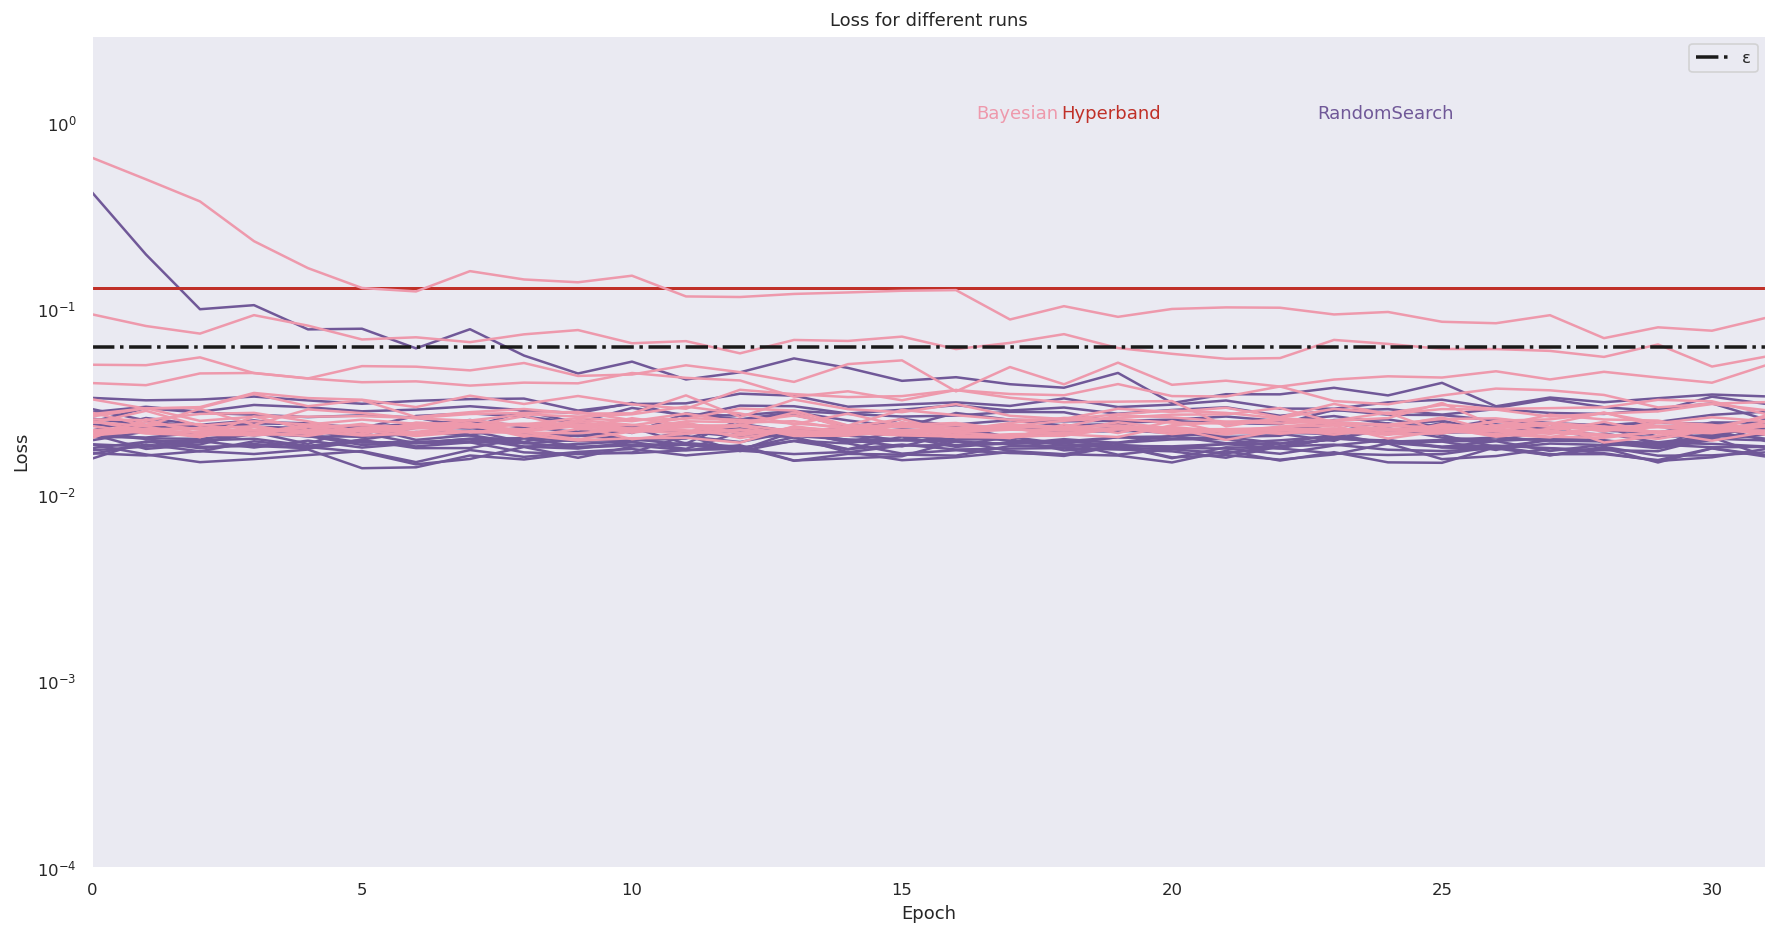

In [32]:
# Tuner initialization
π = []  # List to store the median of losses for each tuner
best_π = []  # List to store the best hyperparameters for each tuner
for i in (data_r['Opt_Set']):
    start0 = time.time()  # Record the start time for each tuner
    if i == 'RandomSearch':
        # Using the Random Search algorithm
        tuner = kt.RandomSearch(
            hypermodel=build_model,
            objective=kt.Objective(data_r['LossSet'][0], direction='min'),  # Objective to minimize
            max_trials=9,  # Maximum number of trials
            executions_per_trial=3,  # Number of executions per trial
            overwrite=True,  # Overwrite directory if it exists
            directory="D"+i,  # Directory to save results
            project_name="RS_Tune"  # Project name
        )
    if i == 'Hyperband':
        # Using the Hyperband search algorithm
        tuner = kt.Hyperband(
            hypermodel=build_model,
            objective=data_r['LossSet'][0],  # Objective to minimize
            max_epochs=9,  # Maximum number of epochs per trial
            hyperband_iterations=2,  # Number of times to perform the search
            factor=3,  # Reduction factor for number of epochs and trials
            seed=42,  # Random seed for reproducibility
            directory="D"+i,  # Directory to save results
            project_name="Hyper_Tune"  # Project name
        )
    if i == 'Bayesian':
        tuner = kt.BayesianOptimization(
            hypermodel=build_model,
            objective=data_r['LossSet'][0],  # Objective to minimize
            max_trials=9,  # Maximum number of trials
            executions_per_trial=2,  # Number of executions per trial
            directory="D"+i,  # Directory to save results
            project_name="Bayes_Tune"  # Project name
        )

    # Define a callback for early stopping
    early_stopping = keras.callbacks.EarlyStopping(
        monitor=data_r['LossSet'][0],  # Monitor the specified loss
        patience=9,  # Number of epochs with no improvement before stopping
        mode='min',  # Minimize the monitored quantity
        restore_best_weights=True  # Restore model weights from the epoch with the best value
    )

    # Run the Tuner
    tuner.search(
        X_train, y_train,  # Training data
        epochs=5,  # Number of epochs
        validation_data=(X_test, y_test),  # Validation data
        callbacks=[keras.callbacks.EarlyStopping()],  # Callback for early stopping
        verbose=0  # Verbosity mode
    )

    # Retrieve the best model and hyperparameters
    best_models = tuner.get_best_models(num_models=1)  # Retrieve the best model
    best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]  # Retrieve the best hyperparameters
    best_π.append(best_hp)  # Store the best hyperparameters

    # Build and train the model with the optimal hyperparameters
    model = tuner.hypermodel.build(best_hp)
    print(f'best values hp{i} ', best_hp.values)

    # Evaluate the Best Model
    test_loss, _ = best_models[0].evaluate(X_test, y_test)
    print(f'Test loss ε[{i}]:', test_loss)

    h = 0
    Σ = []
    while h < data_r['max_iter']:
        start = time.time()  # Record the start time for each iteration
        history = model.fit(
            X_test, y_test,  # Training data
            epochs=data_r['epochs'],  # Number of epochs
            verbose=0  # Verbosity mode
        )
        Σ.append(np.median(history.history['loss']))  # Append median loss to Σ
        h = h + 1
        plt.semilogy(history.history['loss'], color=kolor[len(str(i))])  # Plot loss
    π.append(np.median(Σ) + .5 * np.std(Σ))  # Append median of Σ to π
    print(f'ε[{i}]  = {np.median(Σ) + .5 * np.std(Σ):.6f}, \u0302τ = {(time.time() - start):.2f}')
    print(f'τ_tunner[{i}] = {(time.time() - start0):.2f}')
    plt.text(.12 + .051 * len(str(i)), .9, f'{i}', color=kolor[len(str(i))], transform=plt.gca().transAxes)
    shutil.rmtree("D"+i)  # Remove directory
y_ε = np.mean(π)  # Calculate the mean of π
miny = max(y_ε - 60 * np.std(π), 1e-4)  # Calculate the minimum y value for plotting
maxy = y_ε + 60 * np.std(π)  # Calculate the maximum y value for plotting
plt.xlim(0, data_r['epochs'] - 1)  # Set x-axis limits
plt.ylim(miny, maxy)  # Set y-axis limits
plt.title('Loss for different runs')  # Set plot title
plt.ylabel('Loss')  # Set y-axis label
plt.xlabel('Epoch')  # Set x-axis label
plt.axhline(y=y_ε, color='k', linestyle='-.', label='ε', linewidth=2.1)  # Add horizontal line
plt.legend()  # Add legend
plt.grid()  # Add grid
plt.show()  # Show plot


min ε[ 0] RandomSearch
{'activation': 'linear', 'mean_squared_error': 'm', 'optimizer': 'rmsprop', 'num_layers': 3, 'units1_0': 34, 'activation_0': 'swish', 'dropout_0': 0.4, 'lr': 0.00029455410688347433, 'Loss': 'mean_squared_error', 'units1_1': 34, 'activation_1': 'relu', 'dropout_1': 0.0, 'units1_2': 136, 'activation_2': 'linear', 'dropout_2': 0.0, 'units1_3': 102, 'activation_3': 'swish', 'dropout_3': 0.0}


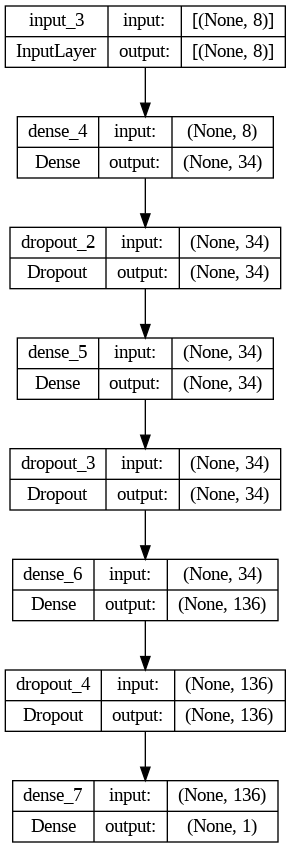

In [33]:
print(f'min ε[ {np.argmin(π)}]', data_r['Opt_Set'][np.argmin(π)])

# Build and train the model with the optimal hyperparameters
model_tuned = tuner.hypermodel.build(best_π[np.argmin(π)])
print(best_π[np.argmin(π)].values)
# display model structure
plot_model(model_tuned, 'best_model.png', show_shapes=True)

https://medium.com/@viniciusqroz/using-keras-tuner-to-find-the-best-parameters-for-your-neural-network-model-2dc02e0a1203
https://blog.paperspace.com/hyperparameter-optimization-with-keras-tuner/
https://haneulkim.medium.com/hyperparameter-tuning-with-keras-tuner-full-tutorial-f8128397e857
https://medium.com/@maslovavictoria/bayesian-hyperparameter-optimization-of-gradient-boosting-machine-6f51996ff5f1
https://towardsdatascience.com/the-art-of-hyperparameter-tuning-in-python-c581a129d4e4
https://medium.com/@redeaddiscolll/deep-learning-for-time-series-forecasting-of-stock-78e4abd6ae30#id_token=eyJhbGciOiJSUzI1NiIsImtpZCI6IjkzNGE1ODE2NDY4Yjk1NzAzOTUzZDE0ZTlmMTVkZjVkMDlhNDAxZTQiLCJ0eXAiOiJKV1QifQ.eyJpc3MiOiJodHRwczovL2FjY291bnRzLmdvb2dsZS5jb20iLCJhenAiOiIyMTYyOTYwMzU4MzQtazFrNnFlMDYwczJ0cDJhMmphbTRsamRjbXMwMHN0dGcuYXBwcy5nb29nbGV1c2VyY29udGVudC5jb20iLCJhdWQiOiIyMTYyOTYwMzU4MzQtazFrNnFlMDYwczJ0cDJhMmphbTRsamRjbXMwMHN0dGcuYXBwcy5nb29nbGV1c2VyY29udGVudC5jb20iLCJzdWIiOiIxMTI2MTk3MDM0MzAyODM1MzE4NjMiLCJlbWFpbCI6ImdjYXN0ZWxsOUBnbWFpbC5jb20iLCJlbWFpbF92ZXJpZmllZCI6dHJ1ZSwibmJmIjoxNzEyMzEwMDUxLCJuYW1lIjoiR2VybWFuIENhc3RlbGxhbm9zIERvbWluZ3VleiIsInBpY3R1cmUiOiJodHRwczovL2xoMy5nb29nbGV1c2VyY29udGVudC5jb20vYS9BQ2c4b2NMUGg5X21UM1RNYmZBWVd4Y2NIVElPTGRkQVpoSmR0MGY1eGpacENTYmR1QkhRMk00Qz1zOTYtYyIsImdpdmVuX25hbWUiOiJHZXJtYW4iLCJmYW1pbHlfbmFtZSI6IkNhc3RlbGxhbm9zIERvbWluZ3VleiIsImlhdCI6MTcxMjMxMDM1MSwiZXhwIjoxNzEyMzEzOTUxLCJqdGkiOiIwNjIxODZjNGQ5NDI3ZTBhMWRlZTFmMzgwYWJiY2QyZTU4NzVlOWM0In0.O_C0SI9o7yP8V7M16K7OHQspRpGsxW3LTFZ3_nVsD7kLG3iMFMVPwJkgI8-XojR8QL3LFqnlEg88j0ZPLqv_7Q6rFJ4Za5A3gYHh09Y8Mu24qBAi3ICZXgh2FE7W41WokL_CTzT02UmHDWSUzdXq14vLHRdhZcw2CCOEX6uZTsNeXK0eWeB2UkrxZmdzXpZZo-3aqEcDQ4JM7c_5InAmkDoS0-ycxMxCH4ZSLJnZWcoe0kLvDz7aieTiaHYI5mrLjJ773Xym7mzqswbhXuTAEeFxO_E2GYLng__ylPkI5JIYyV-NGbGwr0NKT-DnvTSdouFjfNzUqkbJDAvkXCt6vA
https://medium.com/@chenycy/accelerate-your-machine-learning-skills-with-hyperparameter-tuning-00dfd27e261c
https://towardsdatascience.com/tune-deep-neural-networks-using-bayesian-optimization-c9f6503a049f
https://gist.github.com/GermanCM/1943a0dc1eac04f848c6fe9b16947ac4
https://pyimagesearch.com/2021/06/07/easy-hyperparameter-tuning-with-keras-tuner-and-tensorflow/
https://www.peterspython.com/es/blog/lstm-optimizacion-multipaso-hyperparameter-con-keras-tuner


